# 🔍 Fake Account Detection Using Machine Learning

In this notebook, we explore a dataset containing social media account information to identify fake accounts using various data processing and machine learning techniques. We'll perform:

- Data loading and initial exploration
- Data preprocessing
- Exploratory data analysis (EDA)
- Feature selection
- Model training and evaluation
- Comparison of models using metrics like ROC and AUC

In [85]:
#!pip install pdpipe

In [84]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


## 📦 Importing Necessary Libraries

We start by importing essential libraries for data manipulation, visualization, and machine learning.

We'll also load the dataset and display basic information about it.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Make sure module pdpipe is available. 
# You might need to install it via pip install pdpipe
#import pdpipe as pdp
%matplotlib inline

## 📊 Dataset Overview

Let’s look at the structure of the dataset. We'll inspect the data dictionary and understand what each feature represents.

This helps in identifying which columns are numerical, categorical, or need transformation.

In [87]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set max width of cell
pd.options.display.max_colwidth=300

# Suppress scientific notation
np.set_printoptions(suppress=True) 
pd.options.display.float_format = '{:.2f}'.format


# Display all columns
pd.set_option('display.max_columns', None)

# Read data
df_train = pd.read_csv("/home/archita/Documents/datasets/social_media_train/social_media_train.csv",index_col=[0])
display(df_train.head(),df_train.info())


<class 'pandas.core.frame.DataFrame'>
Index: 576 entries, 0 to 575
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fake                   576 non-null    int64  
 1   profile_pic            576 non-null    object 
 2   ratio_numlen_username  576 non-null    float64
 3   len_fullname           576 non-null    int64  
 4   ratio_numlen_fullname  576 non-null    float64
 5   sim_name_username      576 non-null    object 
 6   len_desc               576 non-null    int64  
 7   extern_url             576 non-null    object 
 8   private                576 non-null    object 
 9   num_posts              576 non-null    int64  
 10  num_followers          576 non-null    int64  
 11  num_following          576 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 58.5+ KB


,fake,profile_pic,ratio_numlen_username,len_fullname,ratio_numlen_fullname,sim_name_username,len_desc,extern_url,private,num_posts,num_followers,num_following
0,0,Yes,0.27,0,0.00,No match,53,No,No,32,1000,955
1,0,Yes,0.00,2,0.00,Partial match,44,No,No,286,2740,533
2,0,Yes,0.10,2,0.00,Partial match,0,No,Yes,13,159,98
3,0,Yes,0.00,1,0.00,Partial match,82,No,No,679,414,651
4,0,Yes,0.00,2,0.00,No match,0,No,Yes,6,151,126


None

In [88]:
# Dataset Description
data_dict = pd.read_csv("/home/archita/Documents/datasets/Fake account/fake_account__data_dict.csv", index_col = 'No.')
data_dict


,Column name,Data Type,Description
No.,,,
0,'profile_pic',categorical,Whether the account has a profile picture (1) or not (0)
1,'ratio_numlen_username',numerical (float),Ratio of numeric characters in the account username to its length
2,'len_fullname',numerical (int),Number of characters in the user's full name
3,'ratio_numlen_fullname',numerical (float),Ratio of numeric characters in the user's full name to its length
4,'sim_name_username',categorical,"Whether the user's name matches their username completely (1),not at all (0)."
5,'len_desc',numerical (int),Number of characters in the account description
6,'extern_url',categorical,Whether the account description includes a URL (1) or not (2)
7,'private',categorical,Whether the user's posts are visible only to their followers (1) or to all Instagram users (2).
8,'num_posts',numerical (int),Number of posts in the user account


## 🧹 Data Cleaning & Preprocessing

Here, we:
- Check for missing values
- Identify numerical and categorical columns
- Handle null values (if any)
- Encode categorical variables using label encoding
- Normalize/standardize data where necessary

In [89]:
# Determine categorical and numerical features

# Numerical columns
num_cols = ['ratio_numlen_username','len_fullname','ratio_numlen_fullname',
            'len_desc','num_posts','num_followers',
              'num_following']
# Categorical columns
cat_cols = [col for col in df_train.columns.values.tolist() if col not in num_cols]
cat_cols


['fake', 'profile_pic', 'sim_name_username', 'extern_url', 'private']

In [90]:
# Check descriptive statistics
df_train[num_cols].describe()


,ratio_numlen_username,len_fullname,ratio_numlen_fullname,len_desc,num_posts,num_followers,num_following
count,576.00,576.00,576.00,576.00,576.00,576.00,576.00
mean,0.16,1.46,0.04,22.62,107.49,85307.24,508.38
std,0.21,1.05,0.13,37.70,402.03,910148.46,917.98
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,0.00,39.00,57.50
50%,0.00,1.00,0.00,0.00,9.00,150.50,229.50
75%,0.31,2.00,0.00,34.00,81.50,716.00,589.50
max,0.92,12.00,1.00,150.00,7389.00,15338538.00,7500.00


## 🔍 Exploratory Data Analysis (EDA)

We visualize the data to:
- Understand distributions
- Explore correlations between features
- Compare how fake and non-fake accounts differ

This step helps in identifying patterns that machine learning models can leverage.

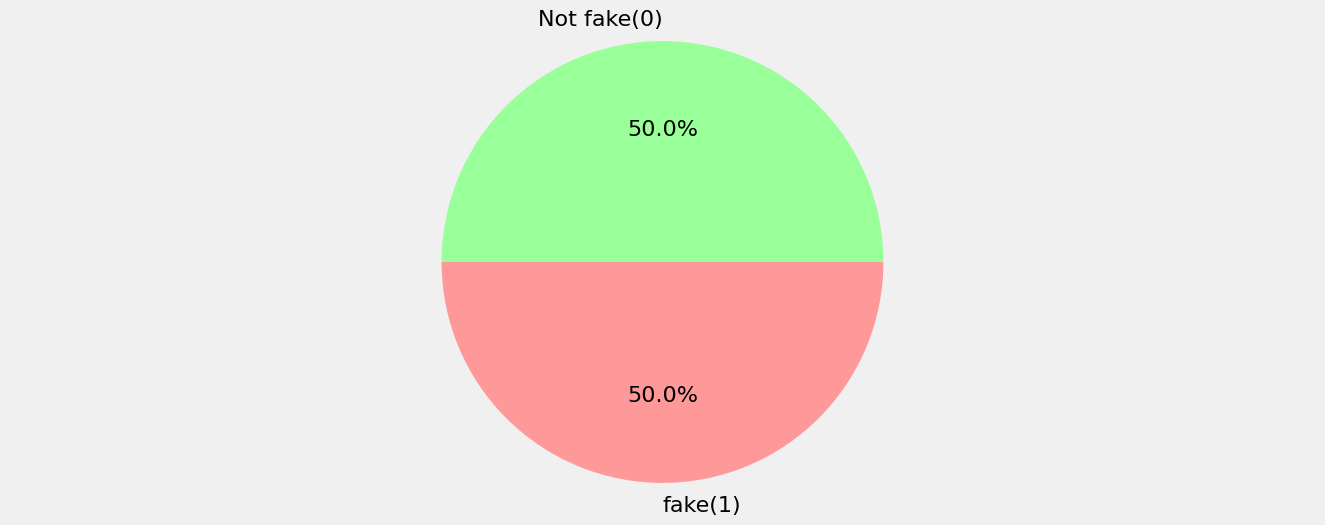

In [91]:
# Get an idea of target category share: fake
plt.figure(figsize=(15,6))
fake_share = df_train["fake"].value_counts()
mylabel=["Not fake(0)","fake(1)"]
colors = ['#99ff99','#ff9999']
plt.pie(fake_share,
        labels=mylabel,autopct="%1.1f%%",colors=colors,
        textprops={'fontsize': 16})
plt.axis("equal");


In [92]:
# Check the percentage of the missing values

percent_missing = df_train.isnull().sum() * 100 / len(df_train)
missing_value_df = pd.DataFrame({'percent_missing (%)': percent_missing})
missing_value_df.sort_values('percent_missing (%)', ascending=False)


,percent_missing (%)
fake,0.00
profile_pic,0.00
ratio_numlen_username,0.00
len_fullname,0.00
ratio_numlen_fullname,0.00
sim_name_username,0.00
len_desc,0.00
extern_url,0.00
private,0.00
num_posts,0.00


In [93]:
# Correlation heatmap
# Colormap: Most negative correlations (dark-blue) to most positive correlation (dark red)
corr = df_train[num_cols].corr()
corr.style.background_gradient(cmap='coolwarm')


,ratio_numlen_username,len_fullname,ratio_numlen_fullname,len_desc,num_posts,num_followers,num_following
ratio_numlen_username,1.000000,-0.225472,0.408567,-0.321170,-0.157442,-0.062785,-0.172413
len_fullname,-0.225472,1.000000,-0.094348,0.272522,0.073350,0.033225,0.094855
ratio_numlen_fullname,0.408567,-0.094348,1.000000,-0.117521,-0.057716,-0.027035,-0.067971
len_desc,-0.321170,0.272522,-0.117521,1.000000,0.144824,0.005929,0.226561
num_posts,-0.157442,0.073350,-0.057716,0.144824,1.000000,0.321385,0.098225
num_followers,-0.062785,0.033225,-0.027035,0.005929,0.321385,1.000000,-0.011066
num_following,-0.172413,0.094855,-0.067971,0.226561,0.098225,-0.011066,1.000000


Text(0.5, 0.98, 'Pair Plot of Characteristics')

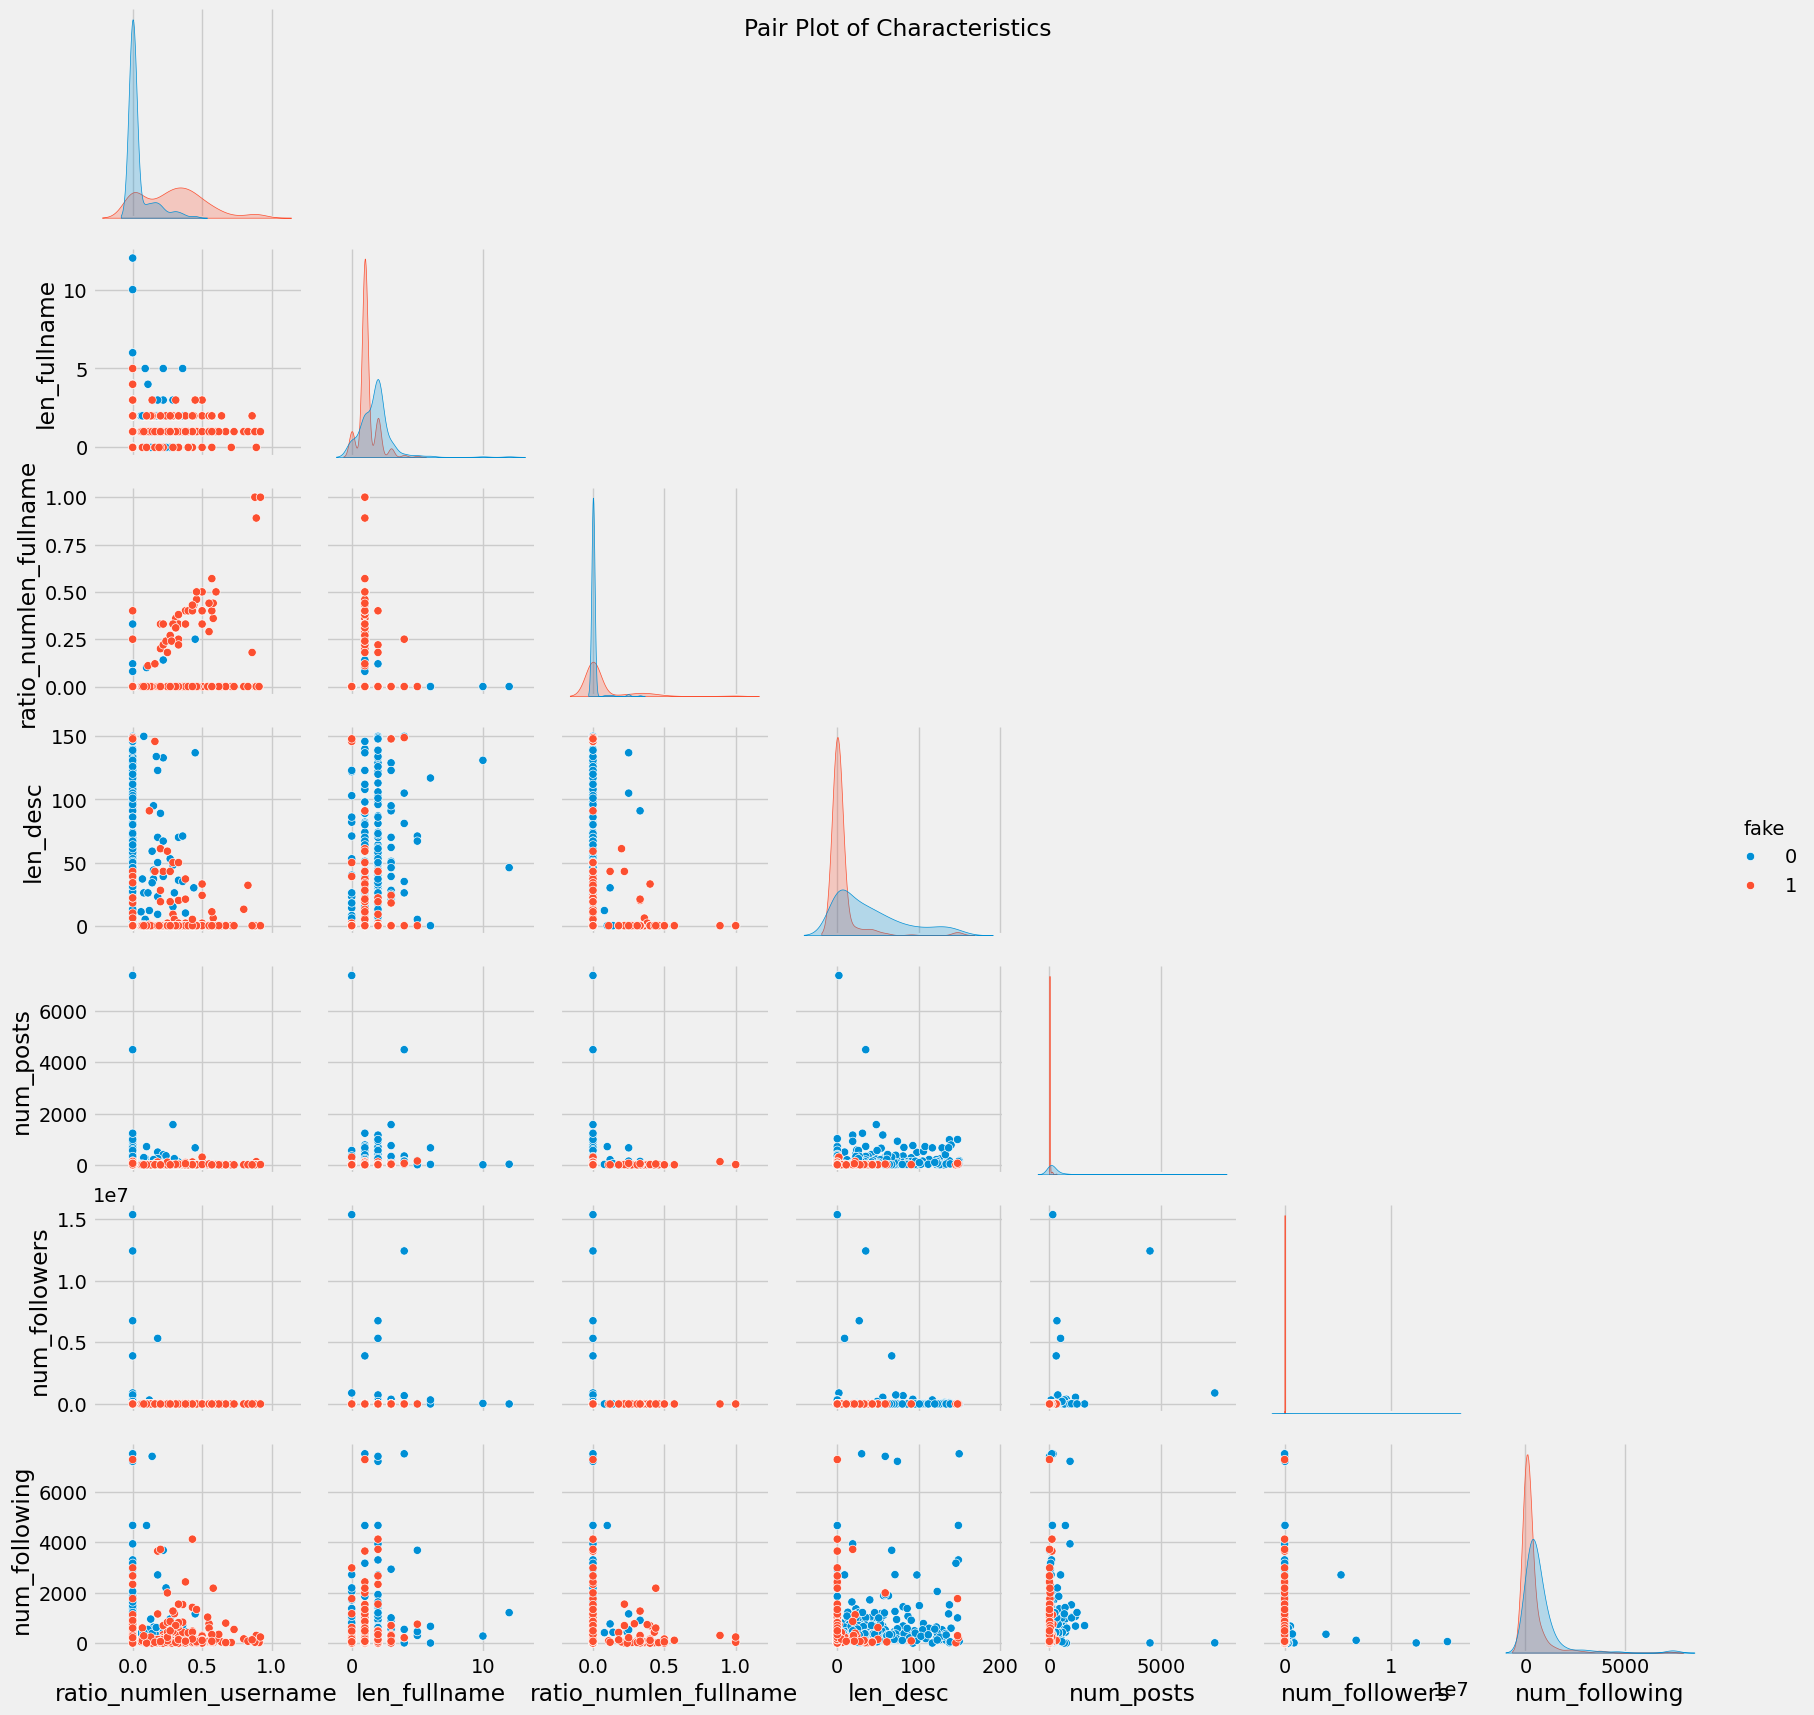

In [94]:
# Pair plot oapif numerical values with fake account information
pp_cols = []
pp_cols = num_cols + ['fake']
ax=sns.pairplot(df_train[pp_cols], hue="fake",corner=True);
plt.style.use('fivethirtyeight')
ax.fig.suptitle("Pair Plot of Characteristics")


In [95]:
# Categorical data
display(df_train.loc[:, cat_cols].head())
print('----------------------')

# Unique values
for col in cat_cols:
    unique_values = df_train.loc[:, col].unique()
    print("\nColumn name: {}\nUnique values: {}".format(col, unique_values))  


,fake,profile_pic,sim_name_username,extern_url,private
0,0,Yes,No match,No,No
1,0,Yes,Partial match,No,No
2,0,Yes,Partial match,No,Yes
3,0,Yes,Partial match,No,No
4,0,Yes,No match,No,Yes


----------------------

Column name: fake
Unique values: [0 1]

Column name: profile_pic
Unique values: ['Yes' 'No']

Column name: sim_name_username
Unique values: ['No match' 'Partial match' 'Full match']

Column name: extern_url
Unique values: ['No' 'Yes']

Column name: private
Unique values: ['No' 'Yes']


In [96]:
import pandas as pd

def label_encoding(df):
    '''
    Function label_encoding() transforms categorical features
    represented by strings to binary features containing only
    0s and 1s, which can be used for machine learning models.
    
    Input:
        df: DataFrame of features
        
    Output:
        New DataFrame with binary features    
    '''
    # Dictionary for label encoding (Yes → 1, No → 0)
    dict_label_encoding = {'Yes': 1, 'No': 0}
    
    # Apply label encoding to specified columns (if they exist)
    for col in ['profile_pic', 'extern_url', 'private']:
        if col in df.columns:
            df[col] = df[col].map(dict_label_encoding).fillna(df[col])  # Retain original values for other cases

    # Apply one-hot encoding for 'sim_name_username' if it exists
    if 'sim_name_username' in df.columns:
        df = pd.get_dummies(df, columns=['sim_name_username'], drop_first=False)  

    return df       

# Apply function label_encoding
df_train = label_encoding(df_train)
print(df_train.head())


   fake  profile_pic  ratio_numlen_username  len_fullname  \
0     0            1                   0.27             0   
1     0            1                   0.00             2   
2     0            1                   0.10             2   
3     0            1                   0.00             1   
4     0            1                   0.00             2   

   ratio_numlen_fullname  len_desc  extern_url  private  num_posts  \
0                   0.00        53           0        0         32   
1                   0.00        44           0        0        286   
2                   0.00         0           0        1         13   
3                   0.00        82           0        0        679   
4                   0.00         0           0        1          6   

   num_followers  num_following  sim_name_username_Full match  \
0           1000            955                         False   
1           2740            533                         False   
2            159 

In [98]:
# Read data
df_test = pd.read_csv("/home/archita/Documents/datasets/archive (7)/social_media_test.csv",index_col=[0])
df_test = label_encoding(df_test)
df_test.head()


,fake,profile_pic,ratio_numlen_username,len_fullname,ratio_numlen_fullname,len_desc,extern_url,private,num_posts,num_followers,num_following,sim_name_username_Full match,sim_name_username_No match,sim_name_username_Partial match
0,0,1,0.33,1,0.33,30,0,1,35,488.00,604,True,False,False
1,0,1,0.00,5,0.00,64,0,1,3,35.00,6,False,False,True
2,0,1,0.00,2,0.00,82,0,1,319,328.00,668,False,False,True
3,0,1,0.00,1,0.00,143,0,1,273,14890.00,7369,False,True,False
4,0,1,0.50,1,0.00,76,0,1,6,225.00,356,False,True,False


## 🤖 Model Training and Evaluation

We train different classification models and evaluate them using metrics like:
- Accuracy
- Precision
- Recall
- ROC Curve
- AUC Score

Both regularized and non-regularized models are tested.

In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression

# 🔹 Load or prepare your dataset (assuming df_train and df_test are already defined)
X_train = df_train.drop('fake', axis=1)
y_train = df_train['fake']
X_test = df_test.drop('fake', axis=1)
y_test = df_test['fake']

# 🔹 Train Logistic Regression Model (Without Regularization)
model_log = LogisticRegression(penalty=None)  # No regularization (✅ Corrected)
model_log.fit(X_train, y_train)  # Train the model

# 🔹 Predict target values for test set
y_pred_log = model_log.predict(X_test)

# 🔹 Model evaluation
precision_log = precision_score(y_test, y_pred_log)
recall_log = recall_score(y_test, y_pred_log)

# 🔹 Print results
print('Precision of model without regularisation: ', precision_log)
print('Recall of model without regularisation: ', recall_log)

########################################################################
# 🔹 With Regularisation
# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training data
X_test_scaled = scaler.transform(X_test)  # Transform test data

# Train Logistic Regression Model with Regularization (L2 by default)
model_reg = LogisticRegression()  # L2 Regularization (default)
model_reg.fit(X_train_scaled, y_train)  # Train the model

# Predict target values from the regularized model
y_pred_reg = model_reg.predict(X_test_scaled)

# Model evaluation
precision_reg = precision_score(y_test, y_pred_reg)
recall_reg = recall_score(y_test, y_pred_reg)

# Print results
print('Precision of model with regularisation: ', precision_reg)
print('Recall of model with regularisation: ', recall_reg)


Precision of model without regularisation:  0.875
Recall of model without regularisation:  0.9333333333333333
Precision of model with regularisation:  0.8813559322033898
Recall of model with regularisation:  0.8666666666666667


In [100]:
# module import
from sklearn.metrics import roc_curve

# calculate roc curve values
def roc_curve_values(model,features,target):
    '''
    Function roc_curve_values estimates the probability
    and return roc_curve values as output.
    
    Input:
        model, feautes as dataframe, target values
    Output:
        False positive rate, recall, target_test_pred_proba
    '''
    # calculate probability
    target_test_pred_proba = model.predict_proba(features) 
    
    # calculate roc curve values
    false_positive_rate, recall, threshold = roc_curve(target,
                                                       target_test_pred_proba[:,1],
                                                       drop_intermediate=False)
    
    return false_positive_rate, recall, target_test_pred_proba    


In [101]:
# Apply function roc_curve_values for model without regularization
false_positive_rate_log, recall_log, target_test_pred_proba_log  = roc_curve_values(model_log,features_test,target_test)


In [102]:
# Apply function roc_curve_values for model with regularization
false_positive_rate_reg, recall_reg, target_test_pred_proba_reg  = roc_curve_values(model_reg,features_test,target_test)


In [103]:
def roc_curve_plot(false_positive_rate,recall,label):
    '''
    Function roc_curve_plot plots ROC
    Input:
        false_positive_rate, recall, label: model type
    Output:
        ROC plot    
    '''
    plt.style.use('fivethirtyeight')
    fig,ax=plt.subplots()
    
    # Reference lines
    # Blue diagonal
    ax.plot([0, 1], ls = "--", label='random model')  
    # Grey vertical
    ax.plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model') 
    # Grey horizontal
    ax.plot([1, 1], c=".7", ls='--')  
    
    # ROC curve
    ax.plot(false_positive_rate,recall, label = label)
    
    # labels
    ax.set_title("Receiver Operating Characteristic")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("Recall")
    ax.legend()


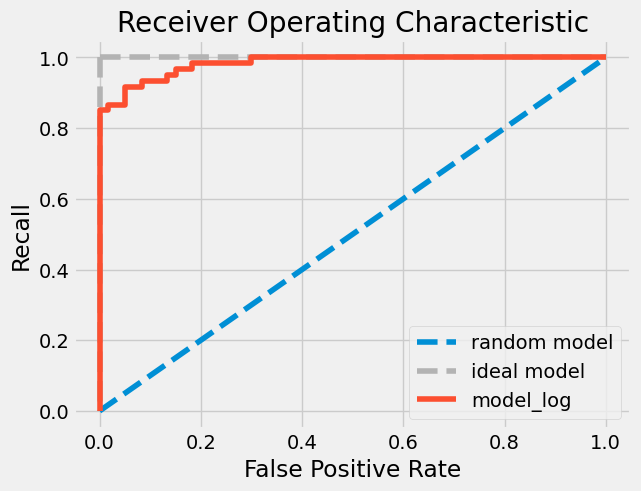

In [104]:
roc_curve_plot(false_positive_rate_log,recall_log,'model_log')


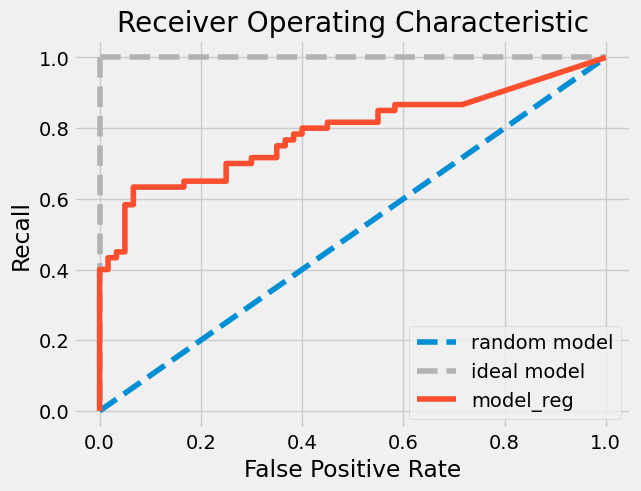

In [105]:
roc_curve_plot(false_positive_rate_reg,recall_reg,'model_reg')


In [106]:
# Import roc_auc_score
from sklearn.metrics import roc_auc_score
print('roc_auc_score for model without regularization', roc_auc_score(target_test, target_test_pred_proba_log[:, 1]))
print('##########################################################')
print('roc_auc_score for model with regularization', roc_auc_score(target_test, target_test_pred_proba_reg[:, 1]))


roc_auc_score for model without regularization 0.9830555555555556
##########################################################
roc_auc_score for model with regularization 0.7877777777777779


Columns in dataset: Index(['fake', 'profile_pic', 'ratio_numlen_username', 'len_fullname',
       'ratio_numlen_fullname', 'sim_name_username', 'len_desc', 'extern_url',
       'private', 'num_posts', 'num_followers', 'num_following'],
      dtype='object')
Data Types:
 fake                       int64
profile_pic               object
ratio_numlen_username    float64
len_fullname               int64
ratio_numlen_fullname    float64
sim_name_username         object
len_desc                   int64
extern_url                object
private                   object
num_posts                  int64
num_followers              int64
num_following              int64
dtype: object
Initial Data Shape: (576, 12)
Selected Features: ['profile_pic', 'ratio_numlen_username', 'len_fullname', 'ratio_numlen_fullname', 'sim_name_username', 'len_desc', 'extern_url', 'num_posts', 'num_followers', 'num_following']
Logistic Regression Accuracy: 0.8793103448275862
              precision    recall  f1-score  

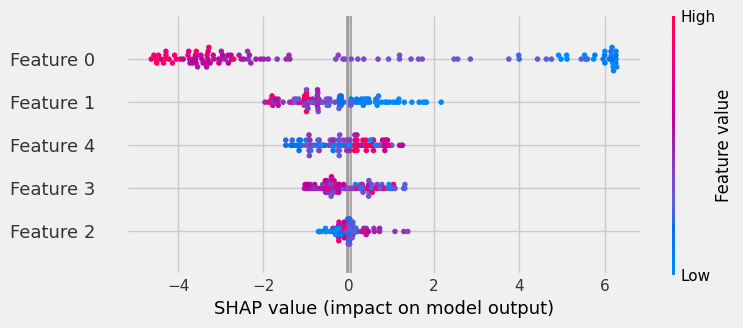

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import shap

warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv("/home/archita/Documents/datasets/social_media_train/social_media_train.csv", index_col=[0])

# Check columns
print("Columns in dataset:", df.columns)
print("Data Types:\n", df.dtypes)

# Identify the correct target column
target_column = "fake"
if target_column not in df.columns:
    raise KeyError(f"Target column '{target_column}' not found in dataset. Available columns: {df.columns}")

# Convert categorical values to numerical
label_encoder = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':  # Convert categorical columns
        df[col] = label_encoder.fit_transform(df[col])

# Data Preprocessing
print("Initial Data Shape:", df.shape)
df.dropna(inplace=True)

# Feature Selection
X = df.drop(columns=[target_column])
y = df[target_column]
selector = SelectKBest(score_func=f_classif, k=min(10, X.shape[1]))
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features.tolist())

# PCA for Dimensionality Reduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
pca = PCA(n_components=min(5, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Anomaly Detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
y_pred_anomaly = iso_forest.fit_predict(X_train)
X_train = X_train[y_pred_anomaly == 1]
y_train = y_train[y_pred_anomaly == 1]

# Convert data to numpy arrays for compatibility
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Classification Model - Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# Classification Model - XGBoost (Direct without GridSearchCV)
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", max_depth=5, learning_rate=0.1, n_estimators=100)
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)

# Evaluation
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# Model Explainability using SHAP
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


## 🧠 Final Thoughts & Conclusion

- Summarize the model performances
- Highlight the most influential features
- Suggest potential improvements or additional steps (like hyperparameter tuning, using more advanced models, etc.)

This project demonstrates how machine learning and data analysis can help identify fake accounts based on profile metrics.